## Statistical Analysis of Astrocytes in Fibrin, VLVGFibrin Hydrogels and PDL

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import copy
import glob
import os
import Graphics
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
# Set colors
palette = Graphics.palette()
bars_palette = sns.color_palette('crest')

## Define base colors for cool sage, soft gold, and coral rose
cool_sage = "#9CAF88"
soft_gold = "#D4AF37"
coral_rose = "#E76F51"
## Create an expanded palette using Seaborn's blend_palette for smooth gradients
markers_palette = sns.color_palette(sns.blend_palette([cool_sage, soft_gold, coral_rose], n_colors=6))
# markers_palette = sns.color_palette("hls", 8)

### Load Annotation CSV

Samples from 3 different biological replaicates (N2, N4 and N6) were imaged in LST700 confocal microscope and annotated using the nuclei segmentation model and the BBValidator tool. The annotation classified astrocytes into 2 types: SOX9+, GFAP+, and accorading to their morphology: Round, Branched, hBranched and Clusters.

In [4]:
# .csv Path with Fiji annotations
annotation_path = "/Users/Beatriz/Documents/Biomédica@IST/Mestrado/Tese/datasets_segmentation/E4WT7DIV__DAPI_SOX9_GFAP/detected_regions_E4WT7DIV.csv"

# Path of the images used for annotation
images_path = "/Users/Beatriz/Documents/Biomédica@IST/Mestrado/Tese/datasets_segmentation/E4WT7DIV__DAPI_SOX9_GFAP/originals cropped"
images_names = [os.path.basename(img_path).split('.')[0] for img_path in glob.glob(f"{images_path}/*")]

# Import .csv file with cell instance labels
df_annotations = pd.read_csv(annotation_path) 
df_filtered = df_annotations[df_annotations["File Name"].isin(images_names)]
df = df_filtered.loc[:, ["File Name", "Segmentation Number", "Morphology Label", "SOX9 Label", "GFAP Label"]].drop_duplicates()

# Show dataframe
df

,File Name,Segmentation Number,Morphology Label,SOX9 Label,GFAP Label
0,E4 WT 7DIV N4 Fibrin P2_00,1,Branched,Positive,Positive
1,E4 WT 7DIV N4 Fibrin P2_00,8,Cluster,Positive,Positive
2,E4 WT 7DIV N4 Fibrin P2_00,9,Cluster,Positive,Positive
3,E4 WT 7DIV N4 Fibrin P2_00,18,Branched,Positive,Positive
4,E4 WT 7DIV N4 Fibrin P2_00,28,Other/Unknown,Positive,Negative
...,...,...,...,...,...
41797,E4 WT 7DIV N3 Fibrin P1_00,5,Other/Unknown,Positive,Negative
41802,E4 WT 7DIV N3 Fibrin P1_00,11,hBranched,Positive,Positive
41824,E4 WT 7DIV N3 Fibrin P1_00,12,Other/Unknown,Positive,Negative
41829,E4 WT 7DIV N3 Fibrin P1_00,8,Branched,Positive,Positive


### Metrics

In this section the data is transformed into a more comprehensive structure for ploting and analysis.

In [5]:
# Images ID
df["Experiment"] = [name.split(" ")[0] for name in df["File Name"]]
df["Replicate"] = [name.split(" ")[3] for name in df["File Name"]]
df["Culture ID"] = [name.split(" ")[4] for name in df["File Name"]]

In [6]:
# Variables
labels = list(df["Morphology Label"].unique())
morphology_labels = ['Round', 'Branched', 'hBranched', 'Cluster', 'Other/Unknown']   # Excluding unlabeled instances
morphology_DoB = ['Round', 'Branched', 'hBranched']                                  # Degree of branching: 0, 1, 2

cultures = ['Fibrin', '5mM', '50mM', '100mM', '175mM', 'PDL']
gel_cultures = ['Fibrin', '5mM', '50mM', '100mM', '175mM']

In [7]:
# Filter dataset for VLVG and FibrinVLVG cultures 
df_hydrogel = df[df["Culture ID"].isin(gel_cultures)]
df_hydrogel

,File Name,Segmentation Number,Morphology Label,SOX9 Label,GFAP Label,Experiment,Replicate,Culture ID
0,E4 WT 7DIV N4 Fibrin P2_00,1,Branched,Positive,Positive,E4,N4,Fibrin
1,E4 WT 7DIV N4 Fibrin P2_00,8,Cluster,Positive,Positive,E4,N4,Fibrin
2,E4 WT 7DIV N4 Fibrin P2_00,9,Cluster,Positive,Positive,E4,N4,Fibrin
3,E4 WT 7DIV N4 Fibrin P2_00,18,Branched,Positive,Positive,E4,N4,Fibrin
4,E4 WT 7DIV N4 Fibrin P2_00,28,Other/Unknown,Positive,Negative,E4,N4,Fibrin
...,...,...,...,...,...,...,...,...
41797,E4 WT 7DIV N3 Fibrin P1_00,5,Other/Unknown,Positive,Negative,E4,N3,Fibrin
41802,E4 WT 7DIV N3 Fibrin P1_00,11,hBranched,Positive,Positive,E4,N3,Fibrin
41824,E4 WT 7DIV N3 Fibrin P1_00,12,Other/Unknown,Positive,Negative,E4,N3,Fibrin
41829,E4 WT 7DIV N3 Fibrin P1_00,8,Branched,Positive,Positive,E4,N3,Fibrin


In [8]:
# Count number of instances of each gel observed in each morphology category

## Create statistics dataframe for the count and percentage calculation of each morphology label
df_stats = pd.DataFrame(columns=["File Name", "Culture ID", "Replicate", "Morphology Label", "Count", "Percentage"])

## Count the number of observations of each morphological label
for id in df["Culture ID"].unique():
    for sample in df[df["Culture ID"] == id]["File Name"].unique():
        replicate = mode(df[df["File Name"] == sample]["Replicate"])
        for morph in morphology_labels:
            count =  len(df[(df["File Name"] == sample) & (df["Morphology Label"] == morph)])
            df_stats.loc[len(df_stats)] = [sample, id, replicate, morph, count, 0]             # Percentage as 0

## Calculate the percentage of each morphological label
for sample in df_stats["File Name"].unique():
    total = df_stats[df_stats["File Name"] == sample]["Count"].sum()
    if total != 0:
        df_stats.loc[df_stats["File Name"] == sample, "Percentage"] = df_stats[df_stats["File Name"] == sample]["Count"] / total * 100

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/755651949.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.26315789 15.78947368  5.26315789 13.15789474 60.52631579]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_stats.loc[df_stats["File Name"] == sample, "Percentage"] = df_stats[df_stats["File Name"] == sample]["Count"] / total * 100


In [9]:
# Filter hydrogel cultures in statistics dataframe
df_stats_gels = df_stats[df_stats["Culture ID"].isin(gel_cultures)]

# Show dataframe
df_stats_gels.groupby("Culture ID").apply(lambda x: x).head(10)

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/470134879.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_stats_gels.groupby("Culture ID").apply(lambda x: x).head(10)


File Name Culture ID Replicate  \
Culture ID                                                       
100mM      160  E4 WT 7DIV N1 100mM P4_11      100mM        N1   
           161  E4 WT 7DIV N1 100mM P4_11      100mM        N1   
           162  E4 WT 7DIV N1 100mM P4_11      100mM        N1   
           163  E4 WT 7DIV N1 100mM P4_11      100mM        N1   
           164  E4 WT 7DIV N1 100mM P4_11      100mM        N1   
           165  E4 WT 7DIV N4 100mM P1_00      100mM        N4   
           166  E4 WT 7DIV N4 100mM P1_00      100mM        N4   
           167  E4 WT 7DIV N4 100mM P1_00      100mM        N4   
           168  E4 WT 7DIV N4 100mM P1_00      100mM        N4   
           169  E4 WT 7DIV N4 100mM P1_00      100mM        N4   

               Morphology Label  Count  Percentage  
Culture ID                                          
100mM      160            Round      0    0.000000  
           161         Branched      3   50.000000  
           162        hBranched      2   33.333333  
           163          Cluster      0    0.000000  
           164    Other/Unknown      1   16.666667  
           165            Round      0    0.000000  
           166         Branched      4   57.142857  
           167        hBranched      2   28.571429  
           168          Cluster      0    0.000000  
           169    Other/Unknown      1   14.285714

In [10]:
df_stats_gels[(df_stats_gels['Culture ID'] == 'Fibrin') & df_stats_gels['Morphology Label'].isin(['Other/Unknown'])]['Count'].sum()

781

In [11]:
# Mean of biological replicates
df_stats_gels_mean = df_stats_gels.groupby(["Culture ID", "Replicate", "Morphology Label"]).mean(numeric_only=True)

## Reset index
df_new_stats_gels = df_stats_gels_mean.reset_index()
df_new_stats_gels.groupby("Culture ID").apply(lambda x: x)

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/3086138001.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_new_stats_gels.groupby("Culture ID").apply(lambda x: x)


Culture ID Replicate Morphology Label   Count  Percentage
Culture ID                                                              
100mM      0        100mM        N1         Branched   2.750   33.700397
           1        100mM        N1          Cluster   0.125    0.892857
           2        100mM        N1    Other/Unknown   2.500   28.541667
           3        100mM        N1            Round   1.250   14.821429
           4        100mM        N1        hBranched   2.375   22.043651
...                   ...       ...              ...     ...         ...
Fibrin     120     Fibrin        N5         Branched  17.000   14.009540
           121     Fibrin        N5          Cluster   2.250    1.712409
           122     Fibrin        N5    Other/Unknown  86.500   72.461452
           123     Fibrin        N5            Round   6.750    5.719761
           124     Fibrin        N5        hBranched   6.750    6.096838

[125 rows x 5 columns]

In [12]:
# Count number of instances of each gel observed in each morphology category according to the degree of branching (DoB)

## Create statistics dataframe for the count and percentage calculation of each morphology label
df_stats_DoB = pd.DataFrame(columns=["File Name", "Culture ID", "Replicate", "Morphology Label", "Count", "Percentage"])

## Count the number of observations of each morphological label
for id in df["Culture ID"].unique():
    for sample in df[df["Culture ID"] == id]["File Name"].unique():
        replicate = mode(df[df["File Name"] == sample]["Replicate"])
        for morph in morphology_DoB:
            count =  len(df[(df["File Name"] == sample) & (df["Morphology Label"] == morph)])
            df_stats_DoB.loc[len(df_stats_DoB)] = [sample, id, replicate, morph, count, 0]             # Percentage as 0

## Calculate the percentage of each morphological label
for sample in df_stats_DoB["File Name"].unique():
    total = df_stats_DoB[df_stats_DoB["File Name"] == sample]["Count"].sum()
    if total != 0:
        df_stats_DoB.loc[df_stats_DoB["File Name"] == sample, "Percentage"] = df_stats_DoB[df_stats_DoB["File Name"] == sample]["Count"] / total * 100

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/4197507203.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[28.57142857 54.28571429 17.14285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_stats_DoB.loc[df_stats_DoB["File Name"] == sample, "Percentage"] = df_stats_DoB[df_stats_DoB["File Name"] == sample]["Count"] / total * 100


In [13]:
# Filter hydrogel cultures in statistics dataframe
df_stats_DoB = df_stats_DoB[df_stats_DoB["Culture ID"].isin(gel_cultures)]

# Shpw dataframe
df_stats_DoB.groupby("Culture ID").apply(lambda x: x).head(10)

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/3980415899.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_stats_DoB.groupby("Culture ID").apply(lambda x: x).head(10)


File Name Culture ID Replicate  \
Culture ID                                                       
100mM      96   E4 WT 7DIV N1 100mM P4_11      100mM        N1   
           97   E4 WT 7DIV N1 100mM P4_11      100mM        N1   
           98   E4 WT 7DIV N1 100mM P4_11      100mM        N1   
           99   E4 WT 7DIV N4 100mM P1_00      100mM        N4   
           100  E4 WT 7DIV N4 100mM P1_00      100mM        N4   
           101  E4 WT 7DIV N4 100mM P1_00      100mM        N4   
           102  E4 WT 7DIV N2 100mM P4_01      100mM        N2   
           103  E4 WT 7DIV N2 100mM P4_01      100mM        N2   
           104  E4 WT 7DIV N2 100mM P4_01      100mM        N2   
           105  E4 WT 7DIV N2 100mM P2_11      100mM        N2   

               Morphology Label  Count  Percentage  
Culture ID                                          
100mM      96             Round      0    0.000000  
           97          Branched      3   60.000000  
           98         hBranched      2   40.000000  
           99             Round      0    0.000000  
           100         Branched      4   66.666667  
           101        hBranched      2   33.333333  
           102            Round      1    5.555556  
           103         Branched     14   77.777778  
           104        hBranched      3   16.666667  
           105            Round      2   11.764706

In [14]:
# Mean of biological replicates
df_stats_DoB_mean = df_stats_DoB.groupby(["Culture ID", "Replicate", "Morphology Label"]).mean(numeric_only=True)

## Reset index
df_new_stats_DoB = df_stats_DoB_mean.reset_index()
df_new_stats_DoB.groupby("Culture ID").apply(lambda x: x)

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/2091089430.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_new_stats_DoB.groupby("Culture ID").apply(lambda x: x)


Culture ID Replicate Morphology Label   Count  Percentage
Culture ID                                                             
100mM      0       100mM        N1         Branched   2.750   50.692155
           1       100mM        N1            Round   1.250   19.670330
           2       100mM        N1        hBranched   2.375   29.637515
           3       100mM        N2         Branched   8.375   50.667649
           4       100mM        N2            Round   2.000   12.753611
...                  ...       ...              ...     ...         ...
Fibrin     70     Fibrin        N4            Round   6.250   31.800073
           71     Fibrin        N4        hBranched   3.250   14.055190
           72     Fibrin        N5         Branched  17.000   54.285714
           73     Fibrin        N5            Round   6.750   21.845238
           74     Fibrin        N5        hBranched   6.750   23.869048

[75 rows x 5 columns]

## Analysis

### Morphology

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/3932983021.py:13: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(data=df_new_stats_gels,


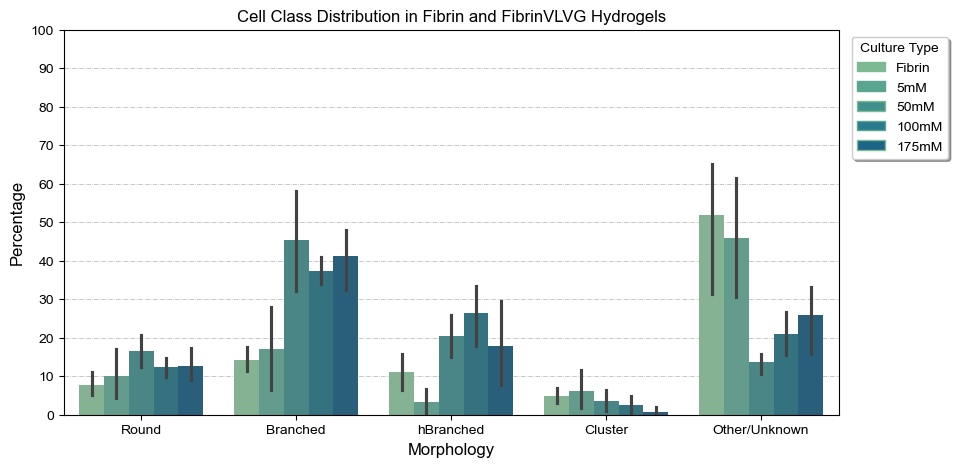

In [15]:
# Percentage of Morphology observations per type of VLVG hydrogel and by biological replicate
from matplotlib.ticker import FixedLocator
## Create figure and subplot
# plt.figure(figsize=(20,5))
fig, ax = plt.subplots(figsize=(10,5))
ax.set_axisbelow(True)
plt.grid(visible=True, which='both', axis='y', linestyle='-.', linewidth=0.5, zorder= -1, ds='steps-mid')

## Set X Position of morphology labels
df_new_stats_gels['X Position'] = [morphology_labels.index(m) for m in df_new_stats_gels["Morphology Label"]]

## Plot mean data and variance
sns.barplot(data=df_new_stats_gels, 
            x="X Position", y = "Percentage", hue="Culture ID",palette=bars_palette, hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM'])

## Create patches for legend
custom_legend = [
    Patch(facecolor=bars_palette[0], edgecolor=bars_palette[0], label='Fibrin'),
    Patch(facecolor=bars_palette[1], edgecolor=bars_palette[1], label='5mM'),
    Patch(facecolor=bars_palette[2], edgecolor=bars_palette[0], label='50mM'),
    Patch(facecolor=bars_palette[3], edgecolor=bars_palette[1], label='100mM'),
    Patch(facecolor=bars_palette[4], edgecolor=bars_palette[0], label='175mM')
]

## Plot each observation and create markers for legend
custom_markers = []
s = 0.16
shift = {'Fibrin':-2*s, '5mM':-s, '50mM':0, '100mM':s, '175mM':2*s}
# shift_rep = [-0.06, -0.03, 0, 0.03, 0.06]

# for c, rep in enumerate(sorted(df_stats_gels["Replicate"].unique())):
#     df_partial = df_stats_gels[(df_stats_gels["Replicate"] == rep)]
#     for gel in gel_cultures:
#         if bool(len(df_partial[df_partial["Culture ID"] == gel])):
#             data = df_partial[df_partial["Culture ID"] == gel]
#             sns.scatterplot(data=data, x=data["X Position"]+shift[gel]+shift_rep[c], y = "Percentage", color=markers_palette[c], legend=False, markers="o", s=10)
#     custom_markers.append(Line2D([0], [0], marker='o', color=markers_palette[c], markerfacecolor=markers_palette[c], markersize=5, label=rep))

## Create legends
legend1 = ax.legend(handles=custom_legend, loc='upper right', title="Culture Type", fancybox=True, shadow=True, bbox_to_anchor=(1.15, 1))
# ax2 = ax.twinx()
# legend2 = ax2.legend(handles=custom_markers,loc='upper left', title="Replicates", fancybox=True, shadow=True, bbox_to_anchor=(1.008, 0.6))

## Titles and labels
plt.title("Cell Class Distribution in Fibrin and FibrinVLVG Hydrogels")
ax.set_xlabel("Morphology")
plt.xticks(ticks=[0,1,2,3,4], labels=morphology_labels)
y_ticks = np.arange(0,110,10)
ax.set_yticks(ticks=y_ticks,labels=list(y_ticks))
# ax2.set_yticks(ticks=[],labels=[])

# fig.subplots_adjust(right=2)

## Save and show graphic
plt.savefig('Images/E4_percentage_bars_morphology.png', transparent=True, dpi=600, bbox_inches = 'tight')
plt.show()

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/271246486.py:13: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(data=df_new_stats_gels,


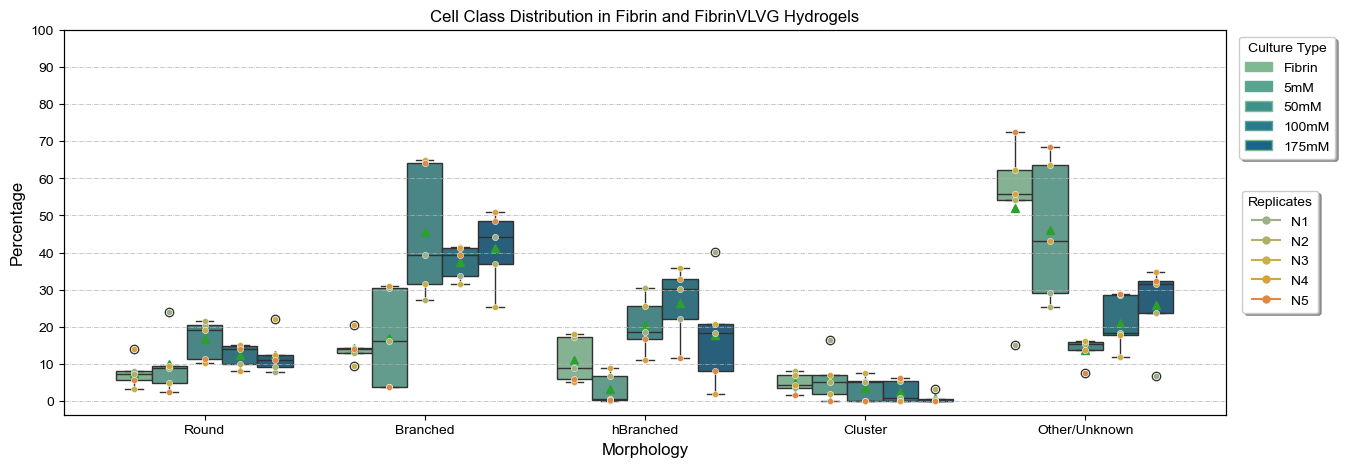

In [16]:
# Percentage of Morphology observations per type of VLVG hydrogel and by biological replicate
from matplotlib.ticker import FixedLocator
## Create figure and subplot
# plt.figure(figsize=(20,5))
fig, ax = plt.subplots(figsize=(15,5))
ax.set_axisbelow(True)
plt.grid(visible=True, which='both', axis='y', linestyle='-.', linewidth=0.5, zorder= -1, ds='steps-mid')

## Set X Position of morphology labels
df_new_stats_gels['X Position'] = [morphology_labels.index(m) for m in df_new_stats_gels["Morphology Label"]]

## Plot mean data and variance
sns.boxplot(data=df_new_stats_gels, 
            x="X Position", y = "Percentage", hue="Culture ID", hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM'],
            palette=bars_palette, linewidth=1, showfliers=True, zorder=0, showmeans=True)

## Create patches for legend
custom_legend = [
    Patch(facecolor=bars_palette[0], edgecolor=bars_palette[0], label='Fibrin'),
    Patch(facecolor=bars_palette[1], edgecolor=bars_palette[1], label='5mM'),
    Patch(facecolor=bars_palette[2], edgecolor=bars_palette[0], label='50mM'),
    Patch(facecolor=bars_palette[3], edgecolor=bars_palette[1], label='100mM'),
    Patch(facecolor=bars_palette[4], edgecolor=bars_palette[0], label='175mM')
]

## Plot each observation and create markers for legend
custom_markers = []
s = 0.16
shift = {'Fibrin':-2*s, '5mM':-s, '50mM':0, '100mM':s, '175mM':2*s}
# shift_rep = [-0.06, -0.03, 0, 0.03, 0.06]

for c, rep in enumerate(sorted(df_new_stats_gels["Replicate"].unique())):
    df_partial = df_new_stats_gels[(df_new_stats_gels["Replicate"] == rep)]
    for gel in gel_cultures:
        if bool(len(df_partial[df_partial["Culture ID"] == gel])):
            data = df_partial[df_partial["Culture ID"] == gel]
            sns.scatterplot(data=data, x=data["X Position"]+shift[gel], y = "Percentage", color=markers_palette[c], legend=False, markers="o", s=20)
    custom_markers.append(Line2D([0], [0], marker='o', color=markers_palette[c], markerfacecolor=markers_palette[c], markersize=5, label=rep))

## Create legends
legend1 = ax.legend(handles=custom_legend, loc='upper right', title="Culture Type", fancybox=True, shadow=True, bbox_to_anchor=(1.1, 1))
ax2 = ax.twinx()
legend2 = ax2.legend(handles=custom_markers,loc='upper left', title="Replicates", fancybox=True, shadow=True, bbox_to_anchor=(1.008, 0.6))

## Titles and labels
plt.title("Cell Class Distribution in Fibrin and FibrinVLVG Hydrogels")
ax.set_xlabel("Morphology")
plt.xticks(ticks=[0,1,2,3,4], labels=morphology_labels)
y_ticks = np.arange(0,110,10)
ax.set_yticks(ticks=y_ticks,labels=list(y_ticks))
ax2.set_yticks(ticks=[],labels=[])

# fig.subplots_adjust(right=2)

## Save and show graphic
plt.savefig('Images/E4_percentage_bars_morphology.png', transparent=True, dpi=600, bbox_inches = 'tight')
plt.show()

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/3509881816.py:13: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(data=df_new_stats_gels,


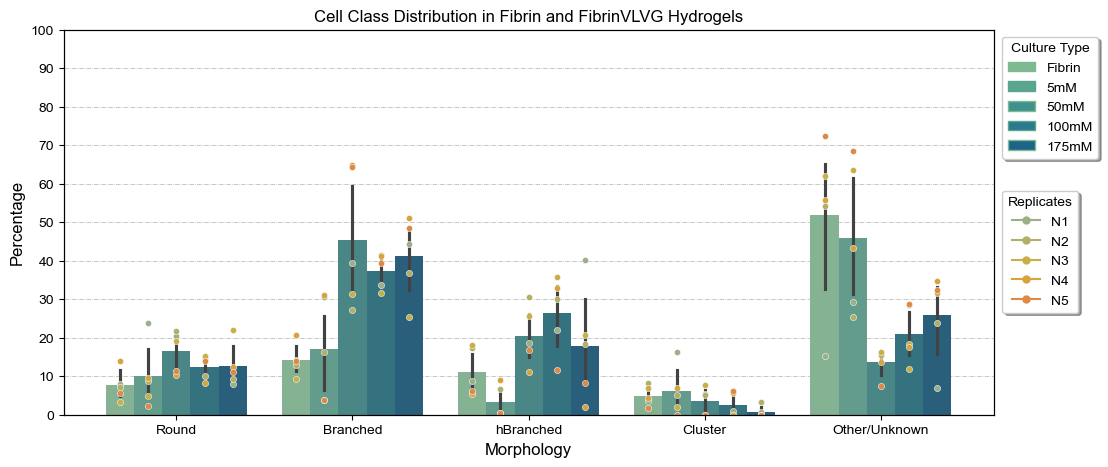

In [17]:
# Percentage of Morphology observations per type of VLVG hydrogel and by biological replicate
from matplotlib.ticker import FixedLocator
## Create figure and subplot
# plt.figure(figsize=(20,5))
fig, ax = plt.subplots(figsize=(12,5))
ax.set_axisbelow(True)
plt.grid(visible=True, which='both', axis='y', linestyle='-.', linewidth=0.5, zorder= -1, ds='steps-mid')

## Set X Position of morphology labels
df_new_stats_gels['X Position'] = [morphology_labels.index(m) for m in df_new_stats_gels["Morphology Label"]]

## Plot mean data and variance
sns.barplot(data=df_new_stats_gels, 
            x="X Position", y = "Percentage", hue="Culture ID",palette=bars_palette, 
            hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM'])

## Create patches for legend
custom_legend = [
    Patch(facecolor=bars_palette[0], edgecolor=bars_palette[0], label='Fibrin'),
    Patch(facecolor=bars_palette[1], edgecolor=bars_palette[1], label='5mM'),
    Patch(facecolor=bars_palette[2], edgecolor=bars_palette[0], label='50mM'),
    Patch(facecolor=bars_palette[3], edgecolor=bars_palette[1], label='100mM'),
    Patch(facecolor=bars_palette[4], edgecolor=bars_palette[0], label='175mM')
]

## Plot each observation and create markers for legend
custom_markers = []
s = 0.16
shift = {'Fibrin':-2*s, '5mM':-s, '50mM':0, '100mM':s, '175mM':2*s}

for c, rep in enumerate(sorted(df_new_stats_gels["Replicate"].unique())):
    df_partial = df_new_stats_gels[(df_new_stats_gels["Replicate"] == rep)]
    for gel in gel_cultures:
        if bool(len(df_partial[df_partial["Culture ID"] == gel])):
            data = df_partial[df_partial["Culture ID"] == gel]
            sns.scatterplot(data=data, x=data["X Position"]+shift[gel], y = "Percentage", color=markers_palette[c], legend=False, markers="o", s=20, zorder = 2)
    custom_markers.append(Line2D([0], [0], marker='o', color=markers_palette[c], markerfacecolor=markers_palette[c], markersize=5, label=rep))

## Create legends
legend1 = ax.legend(handles=custom_legend, loc='upper right', title="Culture Type", fancybox=True, shadow=True, bbox_to_anchor=(1.12, 1))
ax2 = ax.twinx()
legend2 = ax2.legend(handles=custom_markers,loc='upper left', title="Replicates", fancybox=True, shadow=True, bbox_to_anchor=(1.002, 0.6))

## Titles and labels
plt.title("Cell Class Distribution in Fibrin and FibrinVLVG Hydrogels")
ax.set_xlabel("Morphology")
plt.xticks(ticks=[0,1,2,3,4], labels=morphology_labels)
y_ticks = np.arange(0,110,10)
ax.set_yticks(ticks=y_ticks,labels=list(y_ticks))
ax2.set_yticks(ticks=[],labels=[])

# fig.subplots_adjust(right=2)

## Save and show graphic
plt.savefig('Images/E4_percentage_bars_morphology.png', transparent=True, dpi=600, bbox_inches = 'tight')
plt.show()

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/1661119764.py:16: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(data=df_new_stats_DoB,


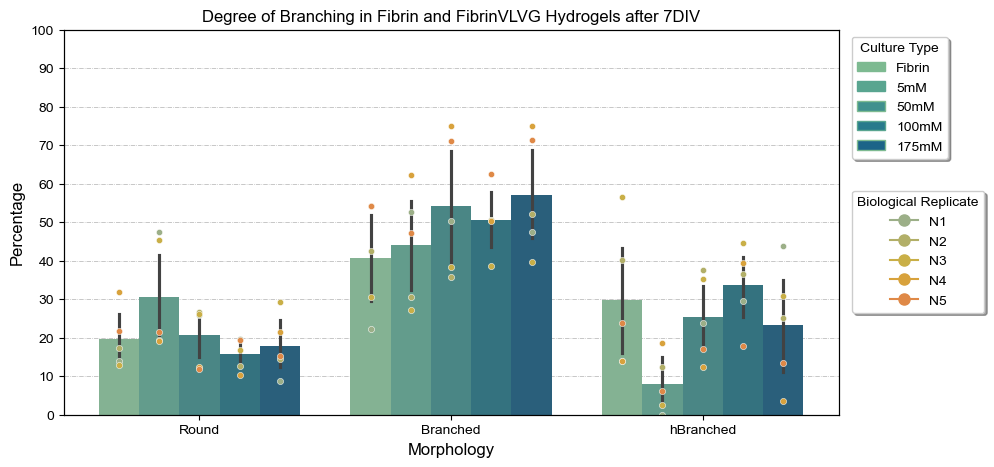

In [18]:
# Percentage of Morphology observations (degree of branching) per type of VLVG hydrogel and by biological replicate

## Create figure and subplot
fig, ax = plt.subplots(figsize=(10,5))
ax.set_axisbelow(True)
plt.grid(visible=True, which='both', axis='y', linestyle='-.', linewidth=0.5, zorder= -1, ds='steps-mid')

# ## Set colors
# bars_palette = [palette[c] for c in ['Deep Teal', 'Fog Gray', 'Slate Blue', 'Aqua Blue', 'Midnight Blue']]
# markers_palette = [palette[c] for c in ['Soft Gold', 'Coral Rose', 'Muted Olive', 'Peach Beige', 'Dusty Lavender']]

## Set X Position of morphology labels
df_new_stats_DoB['X Position'] = [morphology_DoB.index(m) for m in df_new_stats_DoB["Morphology Label"]]

## Plot mean data and variance
sns.barplot(data=df_new_stats_DoB, 
            x="X Position", y = "Percentage", hue="Culture ID", palette=bars_palette, 
            hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM'])

## Create patches for legend
custom_legend = [
    Patch(facecolor=bars_palette[0], edgecolor=bars_palette[0], label='Fibrin'),
    Patch(facecolor=bars_palette[1], edgecolor=bars_palette[1], label='5mM'),
    Patch(facecolor=bars_palette[2], edgecolor=bars_palette[0], label='50mM'),
    Patch(facecolor=bars_palette[3], edgecolor=bars_palette[1], label='100mM'),
    Patch(facecolor=bars_palette[4], edgecolor=bars_palette[0], label='175mM')
]

## Plot each observation and create markers for legend
custom_markers = []
s = 0.16
shift = {'Fibrin':-2*s, '5mM':-s, '50mM':0, '100mM':s, '175mM':2*s}

for c, rep in enumerate(sorted(df_new_stats_DoB["Replicate"].unique())):
    df_partial = df_new_stats_DoB[(df_new_stats_DoB["Replicate"] == rep)]
    for gel in gel_cultures:
        if bool(len(df_partial[df_partial["Culture ID"] == gel])):
            data = df_partial[df_partial["Culture ID"] == gel]
            sns.scatterplot(data=data, x=data["X Position"]+shift[gel], y = "Percentage", color=markers_palette[c], legend=False, s=20, zorder=2)
    custom_markers.append(Line2D([0], [0], marker='o', color=markers_palette[c], markerfacecolor=markers_palette[c], markersize=8, label=rep))

## Create legends
legend1 = ax.legend(handles=custom_legend, loc='upper right', title="Culture Type", fancybox=True, shadow=True, bbox_to_anchor=(1.15, 1))
ax2 = ax.twinx()
legend2 = ax2.legend(handles=custom_markers,loc='upper left', title="Biological Replicate", fancybox=True, shadow=True, bbox_to_anchor=(1.008, 0.6))

## Titles and labels
plt.title("Degree of Branching in Fibrin and FibrinVLVG Hydrogels after 7DIV")
ax.set_xlabel("Morphology")
plt.xticks(ticks=[0,1,2], labels=morphology_DoB)
plt.ylim((0, 100))
y_ticks = np.arange(0,110,10)
ax.set_yticks(ticks=y_ticks,labels=list(y_ticks))
ax2.set_yticks(ticks=[],labels=[])

## Save and show graphic
plt.savefig('Images/E4_percentage_bars_DoB.png', transparent=True, dpi=600, bbox_inches = 'tight')
plt.show()

In [19]:
df_new_stats_DoB[df_new_stats_DoB['Morphology Label'] == 'Round']

ca_concentration = {'5mM': 5,
                    '50mM': 50,
                    '100mM': 100,
                    '175mM':175,
                    'Fibrin': 0}

df_new_stats_DoB["Ca2+ Concentration"] = [ca_concentration[cond] for cond in df_new_stats_DoB['Culture ID']]
df_new_stats_DoB

,Culture ID,Replicate,Morphology Label,Count,Percentage,X Position,Ca2+ Concentration
0,100mM,N1,Branched,2.750,50.692155,1,100
1,100mM,N1,Round,1.250,19.670330,0,100
2,100mM,N1,hBranched,2.375,29.637515,2,100
3,100mM,N2,Branched,8.375,50.667649,1,100
4,100mM,N2,Round,2.000,12.753611,0,100
...,...,...,...,...,...,...,...
70,Fibrin,N4,Round,6.250,31.800073,0,0
71,Fibrin,N4,hBranched,3.250,14.055190,2,0
72,Fibrin,N5,Branched,17.000,54.285714,1,0
73,Fibrin,N5,Round,6.750,21.845238,0,0


In [20]:
from scipy.stats import pearsonr, spearmanr

df_round = df_new_stats_DoB[df_new_stats_DoB['Morphology Label'].isin(["Round"])]

spearmanr(df_round['Ca2+ Concentration'], 1-df_round['Percentage'])

SignificanceResult(statistic=0.25495097567963926, pvalue=0.2187187456163164)

In [21]:
df_new_stats_DoB

,Culture ID,Replicate,Morphology Label,Count,Percentage,X Position,Ca2+ Concentration
0,100mM,N1,Branched,2.750,50.692155,1,100
1,100mM,N1,Round,1.250,19.670330,0,100
2,100mM,N1,hBranched,2.375,29.637515,2,100
3,100mM,N2,Branched,8.375,50.667649,1,100
4,100mM,N2,Round,2.000,12.753611,0,100
...,...,...,...,...,...,...,...
70,Fibrin,N4,Round,6.250,31.800073,0,0
71,Fibrin,N4,hBranched,3.250,14.055190,2,0
72,Fibrin,N5,Branched,17.000,54.285714,1,0
73,Fibrin,N5,Round,6.750,21.845238,0,0


In [22]:
df_new_stats_gels.groupby(["Morphology Label", "Culture ID"]).mean(numeric_only=True).apply(lambda x:x)

Count  Percentage  X Position
Morphology Label Culture ID                                   
Branched         100mM        5.025000   37.446302         1.0
                 175mM        6.691667   41.208756         1.0
                 50mM         5.291667   45.437616         1.0
                 5mM          9.475000   17.128931         1.0
                 Fibrin       7.975000   14.259844         1.0
Cluster          100mM        0.325000    2.539683         3.0
                 175mM        0.241667    0.789108         3.0
                 50mM         0.525000    3.663085         3.0
                 5mM          3.650000    6.114217         3.0
                 Fibrin       1.941667    4.947292         3.0
Other/Unknown    100mM        2.775000   21.060292         4.0
                 175mM        4.208333   25.878601         4.0
                 50mM         1.600000   13.746179         4.0
                 5mM         41.350000   45.982815         4.0
                 Fibrin      31.716667   51.946532         4.0
Round            100mM        1.650000   12.443761         0.0
                 175mM        2.016667   12.568048         0.0
                 50mM         2.308333   16.634789         0.0
                 5mM          5.950000    9.932307         0.0
                 Fibrin       3.475000    7.688770         0.0
hBranched        100mM        3.550000   26.509962         2.0
                 175mM        3.133333   17.888820         2.0
                 50mM         2.825000   20.518332         2.0
                 5mM          2.075000    3.341731         2.0
                 Fibrin       3.791667   11.157562         2.0

In [23]:
np.std([21.060292, 25.878601, 13.746179])

4.987852067020588

In [24]:
# # Percentage of Morphology observations (degree of branching) per type of VLVG hydrogel and by biological replicate

# ## Create figure and subplot
# fig, ax = plt.subplots(figsize=(10,5))
# ax.set_axisbelow(True)
# ax.grid(visible=True, which='both', axis='y', linestyle='-.', linewidth=0.5, zorder=0)

# ## Set X Position of morphology labels
# df_stats_DoB['X Position'] = [morphology_DoB.index(m) for m in df_stats_DoB["Morphology Label"]]

# ## Plot mean data and variance
# sns.violinplot(data=df_stats_DoB, 
#                x="X Position", y = "Percentage", hue="Culture ID", palette=bars_palette, zorder=1, inner='quart', 
#                hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM'])

# ## Create patches for legend
# custom_legend = [
#     Patch(facecolor=bars_palette[0], edgecolor=bars_palette[0], label='Fibrin'),
#     Patch(facecolor=bars_palette[1], edgecolor=bars_palette[1], label='5mM'),
#     Patch(facecolor=bars_palette[2], edgecolor=bars_palette[2], label='50mM'),
#     Patch(facecolor=bars_palette[3], edgecolor=bars_palette[3], label='100mM'),
#     Patch(facecolor=bars_palette[4], edgecolor=bars_palette[4], label='175mM')
# ]

# ## Plot each observation and create markers for legend
# custom_markers = []
# s = 0.16
# shift = {'Fibrin':-2*s, '5mM':-s, '50mM':0, '100mM':s, '175mM':2*s}

# for c, rep in enumerate(sorted(df_stats_DoB["Replicate"].unique())):
#     df_partial = df_stats_DoB[(df_stats_DoB["Replicate"] == rep)]
#     for gel in gel_cultures:
#         if bool(len(df_partial[df_partial["Culture ID"] == gel])):
#             data = df_partial[df_partial["Culture ID"] == gel]
#             sns.scatterplot(data=data, x=data["X Position"]+shift[gel], y = "Percentage", color=markers_palette[c], legend=False, s=8, zorder=2)
#     custom_markers.append(Line2D([0], [0], marker='o', color=markers_palette[c], markerfacecolor=markers_palette[c], markersize=5, label=rep))

# ## Create legends
# legend1 = ax.legend(handles=custom_legend, loc='upper right', title="Culture Type", fancybox=True, shadow=True, bbox_to_anchor=(1.15, 1))
# ax2 = ax.twinx()
# legend2 = ax2.legend(handles=custom_markers,loc='upper left', title="Replicates", fancybox=True, shadow=True, bbox_to_anchor=(1.008, 0.63))

# ## Titles and labels
# plt.title("Degree of Branching in Fibrin and FibrinVLVG Hydrogels")
# ax.set_xlabel("Morphology")
# plt.xticks(ticks=[0,1,2], labels=morphology_DoB)
# y_ticks = np.arange(-20,130,20)
# ax.set_yticks(ticks=y_ticks,labels=list(y_ticks))
# plt.ylim((0, 100))
# ax2.set_yticks(ticks=[],labels=[])


# ## Save and show graphic
# plt.savefig('Images/E4_percentage_violin_DoB.png', transparent=True, dpi=600, bbox_inches = 'tight')
# plt.show()

### Cell Identity

In [25]:
# Create dataframe with cell type statistics

## Allocate dataframe
vlvg_markers_stats = pd.DataFrame(index=df["File Name"].unique())

## Variables
binary_state = {"Positive": "+", "Negative": '-'}
main_markers = ['SOX9','GFAP']

## Ratio over all cells
for marker in main_markers:
    for marker_key, marker_value in binary_state.items():
        for gfp_key, gfp_value in binary_state.items():
            vlvg_markers_stats[f"{marker}{marker_value}DAPI+"] = df[(df[f"{marker} Label"] == marker_key)].value_counts("File Name")

## Ratio SOX9/GFAP
for sox9_key, sox9_value in binary_state.items():
    for gfap_key, gfap_value in binary_state.items():
        vlvg_markers_stats[f"SOX9{sox9_value}GFAP{gfap_value}DAPI+"] = df[(df["SOX9 Label"] == sox9_key) & 
                                                                            (df["GFAP Label"] == gfap_key)].value_counts("File Name")

## Ratio SOX9/GFAP per morphology labelling
for morph in morphology_DoB + ["Cluster"]:
    for sox9_key, sox9_value in binary_state.items():
        for gfap_key, gfap_value in binary_state.items():
            vlvg_markers_stats[f"{morph} SOX9{sox9_value}GFAP{gfap_value}DAPI+"] = df[(df["Morphology Label"] == morph) &
                                                                                        (df["SOX9 Label"] == sox9_key) & 
                                                                                        (df["GFAP Label"] == gfap_key)].value_counts("File Name")

## Image ID and remove NaN
vlvg_markers_stats["Culture ID"] = [file_name.split(' ')[4] for file_name in vlvg_markers_stats.index]
vlvg_markers_stats["Replicate"] = [file_name.split(' ')[3] for file_name in vlvg_markers_stats.index]
vlvg_markers_stats = vlvg_markers_stats.fillna(0)

## Show dataframe
vlvg_markers_stats.head(5)

,SOX9+DAPI+,SOX9-DAPI+,GFAP+DAPI+,GFAP-DAPI+,SOX9+GFAP+DAPI+,SOX9+GFAP-DAPI+,SOX9-GFAP+DAPI+,SOX9-GFAP-DAPI+,Round SOX9+GFAP+DAPI+,Round SOX9+GFAP-DAPI+,...,hBranched SOX9+GFAP+DAPI+,hBranched SOX9+GFAP-DAPI+,hBranched SOX9-GFAP+DAPI+,hBranched SOX9-GFAP-DAPI+,Cluster SOX9+GFAP+DAPI+,Cluster SOX9+GFAP-DAPI+,Cluster SOX9-GFAP+DAPI+,Cluster SOX9-GFAP-DAPI+,Culture ID,Replicate
E4 WT 7DIV N4 Fibrin P2_00,27.0,11.0,15.0,23.0,15.0,12.0,0.0,11.0,2.0,0.0,...,2.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,Fibrin,N4
E4 WT 7DIV N1 100mM P4_11,5.0,1.0,5.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100mM,N1
E4 WT 7DIV N2 PDL P5_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PDL,N2
E4 WT 7DIV N4 100mM P1_00,5.0,2.0,6.0,1.0,5.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,100mM,N4
E4 WT 7DIV N1 175mM P3_01,7.0,2.0,9.0,0.0,7.0,0.0,2.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175mM,N1


In [26]:
# Import .csv file with cell instance labels
annotations_pdl_path = "/Users/Beatriz/Documents/Biomédica@IST/Mestrado/Tese/datasets_segmentation/E1WT7DIV__GFAP_SOX9_GFP_DAPI/annotations_pdl.csv"
pdl_markers_stats = pd.read_csv(annotations_pdl_path, delimiter=";", index_col=0) 

# Image ID and remove NaN
pdl_markers_stats["Culture ID"] = [file_name.split(' ')[4] for file_name in pdl_markers_stats.index]
pdl_markers_stats["Replicate"] = [file_name.split(' ')[3] for file_name in pdl_markers_stats.index]
pdl_markers_stats = pdl_markers_stats.fillna(0)

# Show dataframe
pdl_markers_stats

,DAPI+GFP+,SOX9+DAPI+GFP+,SOX9+GFAP+DAPI+GFP+,SOX9-GFAP+DAPI+GFP+,SOX9-DAPI+GFP+,GFAP+DAPI+GFP+,GFAP-DAPI+GFP+,Culture ID,Replicate
E1 ActinGFP 7DIV N4 PDL P1,295,221,140,16,74,156,139,PDL,N4
E1 ActinGFP 8DIV N6 PDL P1,75,69,61,3,6,64,11,PDL,N6
E1 ActinGFP 8DIV N6 PDL P2,40,29,12,1,11,13,27,PDL,N6
E1 ActinGFP 8DIV N6 PDL P3,69,32,11,2,37,13,56,PDL,N6
E1 ActinGFP 8DIV N6 PDL P4,39,30,19,0,9,19,20,PDL,N6


In [27]:
df_markers_stats = pd.concat([vlvg_markers_stats, pdl_markers_stats]).fillna(0)
df_markers_stats

,SOX9+DAPI+,SOX9-DAPI+,GFAP+DAPI+,GFAP-DAPI+,SOX9+GFAP+DAPI+,SOX9+GFAP-DAPI+,SOX9-GFAP+DAPI+,SOX9-GFAP-DAPI+,Round SOX9+GFAP+DAPI+,Round SOX9+GFAP-DAPI+,...,Cluster SOX9-GFAP-DAPI+,Culture ID,Replicate,DAPI+GFP+,SOX9+DAPI+GFP+,SOX9+GFAP+DAPI+GFP+,SOX9-GFAP+DAPI+GFP+,SOX9-DAPI+GFP+,GFAP+DAPI+GFP+,GFAP-DAPI+GFP+
E4 WT 7DIV N4 Fibrin P2_00,27.0,11.0,15.0,23.0,15.0,12.0,0.0,11.0,2.0,0.0,...,0.0,Fibrin,N4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E4 WT 7DIV N1 100mM P4_11,5.0,1.0,5.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,...,0.0,100mM,N1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E4 WT 7DIV N2 PDL P5_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,PDL,N2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E4 WT 7DIV N4 100mM P1_00,5.0,2.0,6.0,1.0,5.0,0.0,1.0,1.0,0.0,0.0,...,0.0,100mM,N4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E4 WT 7DIV N1 175mM P3_01,7.0,2.0,9.0,0.0,7.0,0.0,2.0,0.0,0.0,0.0,...,0.0,175mM,N1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E1 ActinGFP 7DIV N4 PDL P1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,PDL,N4,295.0,221.0,140.0,16.0,74.0,156.0,139.0
E1 ActinGFP 8DIV N6 PDL P1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,PDL,N6,75.0,69.0,61.0,3.0,6.0,64.0,11.0
E1 ActinGFP 8DIV N6 PDL P2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,PDL,N6,40.0,29.0,12.0,1.0,11.0,13.0,27.0
E1 ActinGFP 8DIV N6 PDL P3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,PDL,N6,69.0,32.0,11.0,2.0,37.0,13.0,56.0


In [28]:
df_markers_stats[df_markers_stats['Culture ID'] == 'PDL']['DAPI+GFP+'].sum()

518.0

In [29]:
df_markers_stats["GFAP-DAPI+"]

E4 WT 7DIV N4 Fibrin P2_00    23.0
E4 WT 7DIV N1 100mM P4_11      1.0
E4 WT 7DIV N2 PDL P5_11        0.0
E4 WT 7DIV N4 100mM P1_00      1.0
E4 WT 7DIV N1 175mM P3_01      0.0
                              ... 
E1 ActinGFP 7DIV N4 PDL P1     0.0
E1 ActinGFP 8DIV N6 PDL P1     0.0
E1 ActinGFP 8DIV N6 PDL P2     0.0
E1 ActinGFP 8DIV N6 PDL P3     0.0
E1 ActinGFP 8DIV N6 PDL P4     0.0
Name: GFAP-DAPI+, Length: 208, dtype: float64

In [30]:
# Create dataframe with SOX9, GFAP and SOX9/GFAP ratios

## Allocate dataframe
df_ratios = pd.DataFrame(index=df_markers_stats.index)

## Percentage of SOX9+ cells in alive (GFP producing) cells
df_ratios["SOX9+/DAPI+"] = df_markers_stats["SOX9+DAPI+"]/(df_markers_stats["SOX9+DAPI+"]+df_markers_stats["SOX9-DAPI+"])

## Percentage of GFAP+ cells in alive (GFP producing) cells
df_ratios["GFAP+/DAPI+"] = df_markers_stats["GFAP+DAPI+"]/(df_markers_stats["GFAP+DAPI+"]+df_markers_stats["GFAP-DAPI+"])

## Percentage of GFAP+ cells in SOX9+ cells
df_ratios["GFAP+/SOX9+"] = df_markers_stats["SOX9+GFAP+DAPI+"]/df_markers_stats["SOX9+DAPI+"]
df_ratios["SOX9-/GFAP+"] = df_markers_stats["SOX9-GFAP+DAPI+"]/df_markers_stats["GFAP+DAPI+"]

## Image ID and remove NaN
df_ratios["Culture ID"] = [file_name.split(' ')[4] for file_name in df_ratios.index]
df_ratios["Replicate"] = [file_name.split(' ')[3] for file_name in df_ratios.index]
df_ratios = df_ratios.fillna(0)

## Filter cultures: VLVG, FibrinVLVG and PDL and show dataframe
cultures = gel_cultures + ['PDL']
df_ratios_filtered = df_ratios[df_ratios["Culture ID"].isin(cultures)]
df_ratios_filtered

,SOX9+/DAPI+,GFAP+/DAPI+,GFAP+/SOX9+,SOX9-/GFAP+,Culture ID,Replicate
E4 WT 7DIV N4 Fibrin P2_00,0.710526,0.394737,0.555556,0.000000,Fibrin,N4
E4 WT 7DIV N1 100mM P4_11,0.833333,0.833333,1.000000,0.000000,100mM,N1
E4 WT 7DIV N2 PDL P5_11,0.000000,0.000000,0.000000,0.000000,PDL,N2
E4 WT 7DIV N4 100mM P1_00,0.714286,0.857143,1.000000,0.166667,100mM,N4
E4 WT 7DIV N1 175mM P3_01,0.777778,1.000000,1.000000,0.222222,175mM,N1
...,...,...,...,...,...,...
E1 ActinGFP 7DIV N4 PDL P1,0.000000,0.000000,0.000000,0.000000,PDL,N4
E1 ActinGFP 8DIV N6 PDL P1,0.000000,0.000000,0.000000,0.000000,PDL,N6
E1 ActinGFP 8DIV N6 PDL P2,0.000000,0.000000,0.000000,0.000000,PDL,N6
E1 ActinGFP 8DIV N6 PDL P3,0.000000,0.000000,0.000000,0.000000,PDL,N6


In [31]:
# Mean of biological replicates
df_ratios_filtered_mean = df_ratios_filtered.groupby(["Culture ID", "Replicate"]).mean(numeric_only=True)

## Reset index
df_new_ratios_filtered = df_ratios_filtered_mean.reset_index()
df_new_ratios_filtered.groupby("Culture ID").apply(lambda x: x)

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/2219581460.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_new_ratios_filtered.groupby("Culture ID").apply(lambda x: x)


Culture ID Replicate  SOX9+/DAPI+  GFAP+/DAPI+  GFAP+/SOX9+  \
Culture ID                                                                  
100mM      0       100mM        N1     0.740476     0.717857     0.885417   
           1       100mM        N2     0.905732     0.824728     0.902243   
           2       100mM        N3     0.909188     0.900641     0.972222   
           3       100mM        N4     0.870879     0.822969     0.910606   
           4       100mM        N5     0.940814     0.711648     0.762879   
175mM      5       175mM        N1     0.891327     0.927246     0.961905   
           6       175mM        N2     0.815863     0.661271     0.716025   
           7       175mM        N3     0.947861     0.702763     0.719792   
           8       175mM        N4     0.891277     0.715498     0.784835   
           9       175mM        N5     0.918087     0.676799     0.738384   
50mM       10       50mM        N1     0.880357     0.894405     0.943909   
           11       50mM        N2     0.985059     0.832217     0.833742   
           12       50mM        N3     0.937500     0.838068     0.900568   
           13       50mM        N4     0.933333     0.862963     0.929630   
           14       50mM        N5     0.940491     0.937500     0.936842   
5mM        15        5mM        N1     0.254879     0.706236     0.930769   
           16        5mM        N2     0.587373     0.397487     0.423115   
           17        5mM        N3     0.489293     0.132003     0.199989   
           18        5mM        N4     0.934842     0.679608     0.724854   
           19        5mM        N5     0.448721     0.081597     0.152854   
Fibrin     20     Fibrin        N1     0.187347     0.382784     0.400893   
           21     Fibrin        N2     0.696084     0.432171     0.636670   
           22     Fibrin        N3     0.767960     0.382371     0.468669   
           23     Fibrin        N4     0.698580     0.449965     0.639826   
           24     Fibrin        N5     0.903221     0.274665     0.296844   
PDL        25        PDL        N2     0.846104     0.641853     0.667118   
           26        PDL        N3     0.751940     0.579876     0.633949   
           27        PDL        N4     0.000000     0.000000     0.000000   
           28        PDL        N6     0.000000     0.000000     0.000000   

               SOX9-/GFAP+  
Culture ID                  
100mM      0      0.090278  
           1      0.006944  
           2      0.025000  
           3      0.041667  
           4      0.000000  
175mM      5      0.075016  
           6      0.031590  
           7      0.025000  
           8      0.017857  
           9      0.000000  
50mM       10     0.063889  
           11     0.013494  
           12     0.000000  
           13     0.000000  
           14     0.060166  
5mM        15     0.666997  
           16     0.007246  
           17     0.024913  
           18     0.000000  
           19     0.072917  
Fibrin     20     0.280258  
           21     0.017361  
           22     0.033333  
           23     0.009259  
           24     0.026226  
PDL        25     0.049687  
           26     0.155414  
           27     0.000000  
           28     0.000000

In [49]:
df_new_ratios_filtered.iloc[27] = ['PDL', 'N4', 0.78737, 0.593749, 0.673937, 0.086363]
df_new_ratios_filtered = df_new_ratios_filtered.drop(index=28)

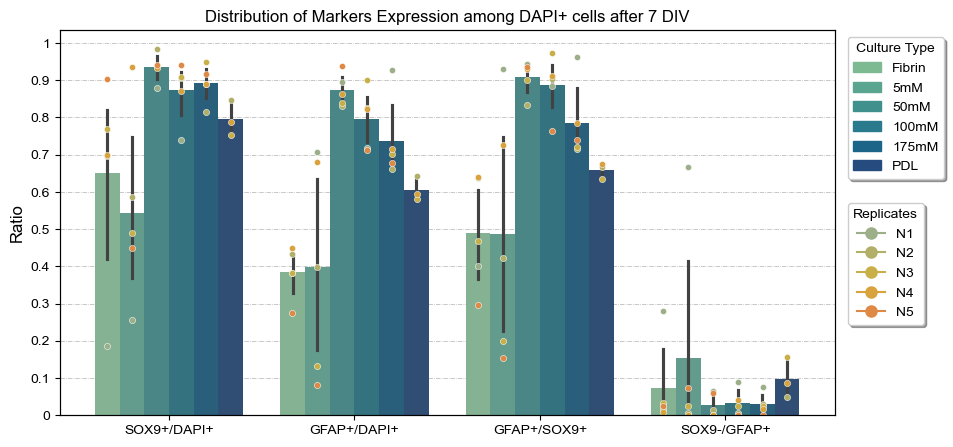

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_axisbelow(True)
ax.grid(visible=True, which='both', axis='y', linestyle='-.', linewidth=0.5, zorder=0)

## Variables
ratios = ["SOX9+/DAPI+", "GFAP+/DAPI+", "GFAP+/SOX9+", "SOX9-/GFAP+"]
s = 0.067
shift = {'Fibrin':-5*s, '5mM':-3*s, '50mM':-s, '100mM':s, '175mM':3*s, 'PDL':5*s}

## Plot the ratios
for x_pos, ratio in enumerate(ratios):
    sns.barplot(data=df_new_ratios_filtered, x=x_pos, y=ratio, hue="Culture ID", palette=bars_palette, width=0.8, estimator='mean', hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM', 'PDL'])
    # sns.boxplot(data=df_new_ratios_filtered, x=x_pos, y=ratio, hue="Culture ID", width=0.8, palette='dark:gray', fill=None, gap=0.5, linewidth=1, showfliers=False, hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM', 'PDL'])
    for c, rep in enumerate(sorted(df_new_ratios_filtered["Replicate"].unique())):
        df_partial = df_new_ratios_filtered[(df_new_ratios_filtered["Replicate"] == rep)]
        for culture in cultures:
            if bool(len(df_partial[df_partial["Culture ID"] == culture])):
                data = df_partial[df_partial["Culture ID"] == culture]
                sns.scatterplot(data=data, x=x_pos+shift[culture], y = ratio, color=markers_palette[c], legend=False, markers="o", s=20, zorder=2)

# Create legends
custom_legend = [
    Patch(facecolor=bars_palette[0], edgecolor=bars_palette[0], label='Fibrin'),
    Patch(facecolor=bars_palette[1], edgecolor=bars_palette[1], label='5mM'),
    Patch(facecolor=bars_palette[2], edgecolor=bars_palette[2], label='50mM'),
    Patch(facecolor=bars_palette[3], edgecolor=bars_palette[3], label='100mM'),
    Patch(facecolor=bars_palette[4], edgecolor=bars_palette[4], label='175mM'),
    Patch(facecolor=bars_palette[5], edgecolor=bars_palette[5], label='PDL')
]

custom_markers = []
for c, rep in enumerate(sorted(df_new_ratios_filtered["Replicate"].unique())):
    custom_markers.append(Line2D([0], [0], marker='o', color=markers_palette[c], markerfacecolor=markers_palette[c], markersize=8, label=rep))
    
## Create legends
legend1 = ax.legend(handles=custom_legend, loc='upper right', title="Culture Type", fancybox=True, shadow=True, bbox_to_anchor=(1.15, 1))
ax2 = ax.twinx()
legend2 = ax2.legend(handles=custom_markers,loc='upper left', title="Replicates", fancybox=True, shadow=True, bbox_to_anchor=(1.008, 0.57))


## Titles and labels
plt.title("Distribution of Markers Expression among DAPI+ cells after 7 DIV")
# ax.set_xlabel("Metric")
ax.set_ylabel("Ratio")
plt.xticks(ticks=np.arange(len(ratios)), labels=ratios)
y_ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax.set_yticks(ticks=y_ticks,labels=list(y_ticks))
ax2.set_yticks(ticks=[],labels=[])

## Save and show graphic
plt.savefig('Images/E4_ratio_sox9gfap.png', transparent=True, dpi=600, bbox_inches = 'tight')
plt.show()

In [ ]:
df_new_ratios_filtered = df_new_ratios_filtered[df_new_ratios_filtered]

In [43]:
df_new_ratios_filtered.groupby(['Culture ID']).apply(lambda x:x)

/var/folders/ml/978gv1hs5yv185y4wyk_hfgw0000gn/T/ipykernel_1750/563000703.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_new_ratios_filtered.groupby(['Culture ID']).apply(lambda x:x)


Culture ID Replicate  SOX9+/DAPI+  GFAP+/DAPI+  GFAP+/SOX9+  \
Culture ID                                                                  
100mM      0       100mM        N1     0.740476     0.717857     0.885417   
           1       100mM        N2     0.905732     0.824728     0.902243   
           2       100mM        N3     0.909188     0.900641     0.972222   
           3       100mM        N4     0.870879     0.822969     0.910606   
           4       100mM        N5     0.940814     0.711648     0.762879   
175mM      5       175mM        N1     0.891327     0.927246     0.961905   
           6       175mM        N2     0.815863     0.661271     0.716025   
           7       175mM        N3     0.947861     0.702763     0.719792   
           8       175mM        N4     0.891277     0.715498     0.784835   
           9       175mM        N5     0.918087     0.676799     0.738384   
50mM       10       50mM        N1     0.880357     0.894405     0.943909   
           11       50mM        N2     0.985059     0.832217     0.833742   
           12       50mM        N3     0.937500     0.838068     0.900568   
           13       50mM        N4     0.933333     0.862963     0.929630   
           14       50mM        N5     0.940491     0.937500     0.936842   
5mM        15        5mM        N1     0.254879     0.706236     0.930769   
           16        5mM        N2     0.587373     0.397487     0.423115   
           17        5mM        N3     0.489293     0.132003     0.199989   
           18        5mM        N4     0.934842     0.679608     0.724854   
           19        5mM        N5     0.448721     0.081597     0.152854   
Fibrin     20     Fibrin        N1     0.187347     0.382784     0.400893   
           21     Fibrin        N2     0.696084     0.432171     0.636670   
           22     Fibrin        N3     0.767960     0.382371     0.468669   
           23     Fibrin        N4     0.698580     0.449965     0.639826   
           24     Fibrin        N5     0.903221     0.274665     0.296844   
PDL        25        PDL        N2     0.846104     0.641853     0.667118   
           26        PDL        N3     0.751940     0.579876     0.633949   
           27        PDL        N4     0.000000     0.000000     0.000000   
           28        PDL        N6     0.000000     0.000000     0.000000   

               SOX9-/GFAP+  
Culture ID                  
100mM      0      0.090278  
           1      0.006944  
           2      0.025000  
           3      0.041667  
           4      0.000000  
175mM      5      0.075016  
           6      0.031590  
           7      0.025000  
           8      0.017857  
           9      0.000000  
50mM       10     0.063889  
           11     0.013494  
           12     0.000000  
           13     0.000000  
           14     0.060166  
5mM        15     0.666997  
           16     0.007246  
           17     0.024913  
           18     0.000000  
           19     0.072917  
Fibrin     20     0.280258  
           21     0.017361  
           22     0.033333  
           23     0.009259  
           24     0.026226  
PDL        25     0.049687  
           26     0.155414  
           27     0.000000  
           28     0.000000

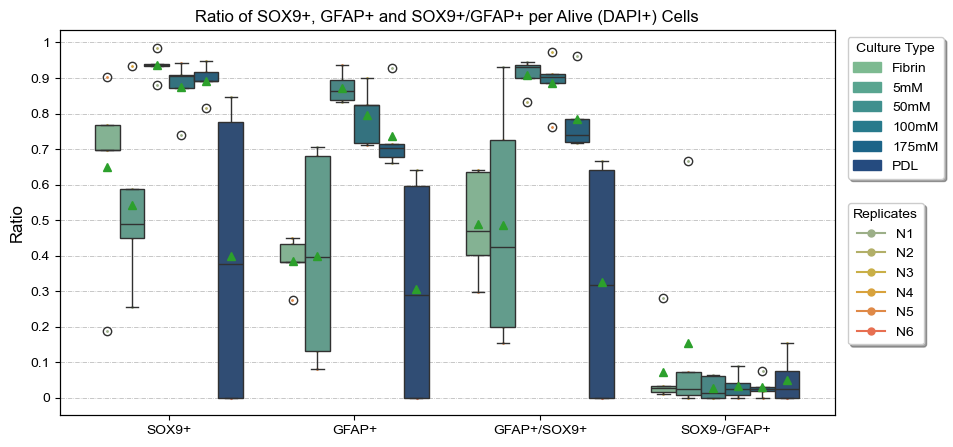

In [44]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_axisbelow(True)
ax.grid(visible=True, which='both', axis='y', linestyle='-.', linewidth=0.5, zorder=0)

## Variables
ratios = ["SOX9+/DAPI+", "GFAP+/DAPI+", "GFAP+/SOX9+", "SOX9-/GFAP+"]
s = 0.067
shift = {'Fibrin':-5*s, '5mM':-3*s, '50mM':-s, '100mM':s, '175mM':3*s, 'PDL':5*s}

## Plot the ratios
for x_pos, ratio in enumerate(ratios):
    # sns.barplot(data=df_ratios_filtered, x=x_pos, y=ratio, hue="Culture ID", palette=bars_palette, width=0.8, errorbar=None, estimator='mean', hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM', 'PDL'])
    sns.boxplot(data=df_new_ratios_filtered, x=x_pos, y=ratio, hue="Culture ID", width=0.8, 
                palette=bars_palette, linewidth=1, showfliers=True, showmeans=True,
                hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM', 'PDL'])
    for c, rep in enumerate(sorted(df_new_ratios_filtered["Replicate"].unique())):
        df_partial = df_new_ratios_filtered[(df_new_ratios_filtered["Replicate"] == rep)]
        for culture in cultures:
            if bool(len(df_partial[df_partial["Culture ID"] == culture])):
                data = df_partial[df_partial["Culture ID"] == culture]
                sns.scatterplot(data=data, x=x_pos+shift[culture], y = ratio, color=markers_palette[c], legend=False, markers="o", s=5)

# Create legends
custom_legend = [
    Patch(facecolor=bars_palette[0], edgecolor=bars_palette[0], label='Fibrin'),
    Patch(facecolor=bars_palette[1], edgecolor=bars_palette[1], label='5mM'),
    Patch(facecolor=bars_palette[2], edgecolor=bars_palette[2], label='50mM'),
    Patch(facecolor=bars_palette[3], edgecolor=bars_palette[3], label='100mM'),
    Patch(facecolor=bars_palette[4], edgecolor=bars_palette[4], label='175mM'),
    Patch(facecolor=bars_palette[5], edgecolor=bars_palette[5], label='PDL')
]

custom_markers = []
for c, rep in enumerate(sorted(df_new_ratios_filtered["Replicate"].unique())):
    custom_markers.append(Line2D([0], [0], marker='o', color=markers_palette[c], markerfacecolor=markers_palette[c], markersize=5, label=rep))
    
## Create legends
legend1 = ax.legend(handles=custom_legend, loc='upper right', title="Culture Type", fancybox=True, shadow=True, bbox_to_anchor=(1.15, 1))
ax2 = ax.twinx()
legend2 = ax2.legend(handles=custom_markers,loc='upper left', title="Replicates", fancybox=True, shadow=True, bbox_to_anchor=(1.008, 0.57))


## Titles and labels
plt.title("Ratio of SOX9+, GFAP+ and SOX9+/GFAP+ per Alive (DAPI+) Cells")
# ax.set_xlabel("Metric")
ax.set_ylabel("Ratio")
plt.xticks(ticks=np.arange(len(ratios)), labels=["SOX9+", "GFAP+", "GFAP+/SOX9+", "SOX9-/GFAP+"])
y_ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax.set_yticks(ticks=y_ticks,labels=list(y_ticks))
ax2.set_yticks(ticks=[],labels=[])

## Save and show graphic
plt.savefig('Images/E4_ratio_sox9gfap.png', transparent=True, dpi=600, bbox_inches = 'tight')
plt.show()

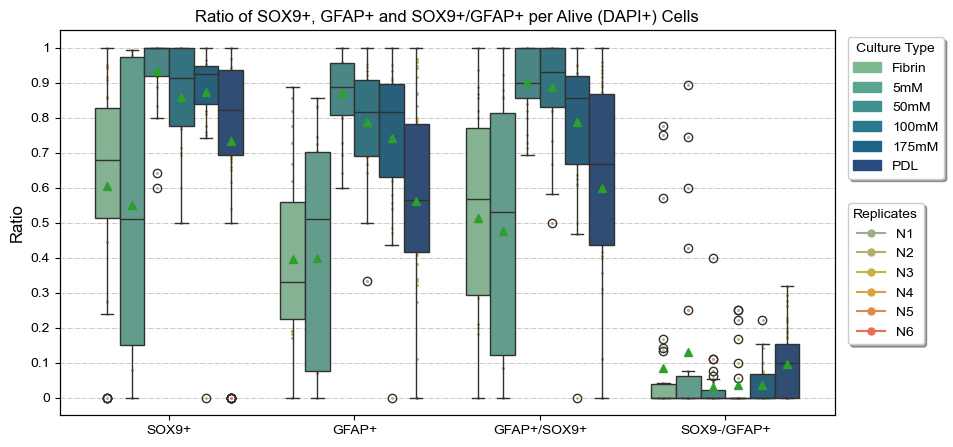

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_axisbelow(True)
ax.grid(visible=True, which='both', axis='y', linestyle='-.', linewidth=0.5, zorder=0)

## Variables
ratios = ["SOX9+/DAPI+", "GFAP+/DAPI+", "GFAP+/SOX9+", "SOX9-/GFAP+"]
s = 0.067
shift = {'Fibrin':-5*s, '5mM':-3*s, '50mM':-s, '100mM':s, '175mM':3*s, 'PDL':5*s}

## Plot the ratios
for x_pos, ratio in enumerate(ratios):
    # sns.barplot(data=df_ratios_filtered, x=x_pos, y=ratio, hue="Culture ID", palette=bars_palette, width=0.8, errorbar=None, estimator='mean', hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM', 'PDL'])
    sns.boxplot(data=df_ratios_filtered, x=x_pos, y=ratio, hue="Culture ID", width=0.8, 
                palette=bars_palette, linewidth=1, showfliers=True, showmeans=True,
                hue_order=['Fibrin', '5mM', '50mM', '100mM', '175mM', 'PDL'])
    for c, rep in enumerate(sorted(df_ratios_filtered["Replicate"].unique())):
        df_partial = df_ratios_filtered[(df_ratios_filtered["Replicate"] == rep)]
        for culture in cultures:
            if bool(len(df_partial[df_partial["Culture ID"] == culture])):
                data = df_partial[df_partial["Culture ID"] == culture]
                sns.scatterplot(data=data, x=x_pos+shift[culture], y = ratio, color=markers_palette[c], legend=False, markers="o", s=5)

# Create legends
custom_legend = [
    Patch(facecolor=bars_palette[0], edgecolor=bars_palette[0], label='Fibrin'),
    Patch(facecolor=bars_palette[1], edgecolor=bars_palette[1], label='5mM'),
    Patch(facecolor=bars_palette[2], edgecolor=bars_palette[2], label='50mM'),
    Patch(facecolor=bars_palette[3], edgecolor=bars_palette[3], label='100mM'),
    Patch(facecolor=bars_palette[4], edgecolor=bars_palette[4], label='175mM'),
    Patch(facecolor=bars_palette[5], edgecolor=bars_palette[5], label='PDL')
]

custom_markers = []
for c, rep in enumerate(sorted(df_ratios_filtered["Replicate"].unique())):
    custom_markers.append(Line2D([0], [0], marker='o', color=markers_palette[c], markerfacecolor=markers_palette[c], markersize=5, label=rep))
    
## Create legends
legend1 = ax.legend(handles=custom_legend, loc='upper right', title="Culture Type", fancybox=True, shadow=True, bbox_to_anchor=(1.15, 1))
ax2 = ax.twinx()
legend2 = ax2.legend(handles=custom_markers,loc='upper left', title="Replicates", fancybox=True, shadow=True, bbox_to_anchor=(1.008, 0.57))


## Titles and labels
plt.title("Ratio of SOX9+, GFAP+ and SOX9+/GFAP+ per Alive (DAPI+) Cells")
# ax.set_xlabel("Metric")
ax.set_ylabel("Ratio")
plt.xticks(ticks=np.arange(len(ratios)), labels=["SOX9+", "GFAP+", "GFAP+/SOX9+", "SOX9-/GFAP+"])
y_ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax.set_yticks(ticks=y_ticks,labels=list(y_ticks))
ax2.set_yticks(ticks=[],labels=[])

## Save and show graphic
plt.savefig('Images/E4_ratio_sox9gfap.png', transparent=True, dpi=600, bbox_inches = 'tight')
plt.show()

In [35]:
df_ratios_filtered_2 = df_ratios_filtered[df_ratios_filtered["Culture ID"].isin(["50mM", "100mM", "175mM"])].groupby(["Replicate"]).mean(numeric_only=True).apply(lambda x:x)
df_ratios_filtered_3 = df_ratios_filtered[df_ratios_filtered["Culture ID"].isin(["PDL"])].groupby(["Replicate"]).mean(numeric_only=True).apply(lambda x:x)

df_ratios_filtered_2['SOX9+/DAPI+'].std()

0.039060937041539165

In [36]:
df_ratios_filtered_3['GFAP+/SOX9+']

Replicate
N2    0.667118
N3    0.633949
N4    0.000000
N6    0.000000
Name: GFAP+/SOX9+, dtype: float64

In [37]:
from scipy.stats import ttest_ind

ttest_ind(df_ratios_filtered_2['GFAP+/SOX9+'], df_ratios_filtered_3['GFAP+/SOX9+'])


TtestResult(statistic=3.1767990572016713, pvalue=0.015559821365441056, df=7.0)

#### T2: Selection of astrocytes hydrogels vs pdl

In [38]:
selection = df_ratios_filtered[df_ratios_filtered['Culture ID'].isin(['PDL', '50mM', '100mM', '175mM'])]

In [39]:
a = selection[selection['Culture ID'] == 'PDL'].groupby('Replicate').mean(numeric_only=True).apply(lambda x:x)["SOX9+/DAPI+"]
b = selection[selection['Culture ID'] != 'PDL'].groupby('Replicate').mean(numeric_only=True).apply(lambda x:x)["SOX9+/DAPI+"]

from scipy.stats import ttest_ind

ttest_ind(a,b)

TtestResult(statistic=-2.4378372526493823, pvalue=0.04490119768834358, df=7.0)

#### T3: correlation GFAP with ca2+ concentration

In [40]:
df_ratios_filtered_2 = df_ratios_filtered[df_ratios_filtered["Culture ID"].isin(["50mM", "100mM", "175mM"])].groupby(["Replicate", "Culture ID"]).mean(numeric_only=True).apply(lambda x:x)
df_ratios_filtered_2[['GFAP+/DAPI+', 'Ca2+ Concentration']]

KeyError: "['Ca2+ Concentration'] not in index"

In [57]:
ca_concentration = {'5mM': 5,
                    '50mM': 50,
                    '100mM': 100,
                    '175mM':175,
                    'Fibrin': 0,
                    'PDL': -1}

df_ratios_filtered["Ca2+ Concentration"] = [ca_concentration[cond] for cond in df_ratios_filtered['Culture ID']]

df_ratios_filtered

,SOX9+/DAPI+,GFAP+/DAPI+,GFAP+/SOX9+,SOX9-/GFAP+,Culture ID,Replicate,Ca2+ Concentration
E4 WT 7DIV N4 Fibrin P2_00,0.710526,0.394737,0.555556,0.000000,Fibrin,N4,0
E4 WT 7DIV N1 100mM P4_11,0.833333,0.833333,1.000000,0.000000,100mM,N1,100
E4 WT 7DIV N2 PDL P5_11,0.000000,0.000000,0.000000,0.000000,PDL,N2,-1
E4 WT 7DIV N4 100mM P1_00,0.714286,0.857143,1.000000,0.166667,100mM,N4,100
E4 WT 7DIV N1 175mM P3_01,0.777778,1.000000,1.000000,0.222222,175mM,N1,175
...,...,...,...,...,...,...,...
E1 ActinGFP 7DIV N4 PDL P1,0.000000,0.000000,0.000000,0.000000,PDL,N4,-1
E1 ActinGFP 8DIV N6 PDL P1,0.000000,0.000000,0.000000,0.000000,PDL,N6,-1
E1 ActinGFP 8DIV N6 PDL P2,0.000000,0.000000,0.000000,0.000000,PDL,N6,-1
E1 ActinGFP 8DIV N6 PDL P3,0.000000,0.000000,0.000000,0.000000,PDL,N6,-1


In [64]:
from scipy.stats import pearsonr

pearsonr(df_ratios_filtered_2['GFAP+/SOX9+'], df_ratios_filtered_2['Ca2+ Concentration'])

PearsonRResult(statistic=-0.5939700563205802, pvalue=0.019557900259026404)

In [63]:
pearsonr(df_ratios_filtered_2['GFAP+/DAPI+'], df_ratios_filtered_2['Ca2+ Concentration'])

PearsonRResult(statistic=-0.5947430638956848, pvalue=0.019359397259102358)

## Correlation Branching and Identity

In [88]:
df['Culture ID'].unique()

array(['Fibrin', '100mM', 'PDL', '175mM', '50mM', '5mM'], dtype=object)

In [110]:
df

dummies = pd.get_dummies(df[df["Culture ID"].isin(['Fibrin', '100mM', '175mM', '50mM', '5mM'])], columns=["Morphology Label"], prefix="Morph")
dummies = pd.get_dummies(dummies, columns=["SOX9 Label"], prefix="SOX9")
dummies = pd.get_dummies(dummies, columns=["GFAP Label"], prefix="GFAP")


dummies = dummies.drop(dummies[(dummies['GFAP_Unknown'] == 1) | (dummies['SOX9_Unknown'] == 1)].index)
dummies = dummies.drop(['SOX9_Unknown', 'GFAP_Unknown', 'Morph_Unknown'], axis=1)
dummies.columns

Index(['File Name', 'Segmentation Number', 'Experiment', 'Replicate',
       'Culture ID', 'Morph_Branched', 'Morph_Cluster', 'Morph_Other/Unknown',
       'Morph_Round', 'Morph_hBranched', 'SOX9_Negative', 'SOX9_Positive',
       'GFAP_Negative', 'GFAP_Positive'],
      dtype='object')

In [112]:
dummies['Culture ID'].unique()

array(['Fibrin', '100mM', '175mM', '50mM', '5mM'], dtype=object)

[[ 0.1143802   0.05083525  0.04364599  0.10433236  0.05963789]
 [ 0.16709957  0.11641114  0.09190252  0.20593635  0.18342284]
 [ 0.10155398  0.11759269  0.09097591  0.19469379  0.09804808]
 [ 0.09624404 -0.00226744 -0.01154395 -0.01437321 -0.06491821]
 [-0.29172024 -0.16390505 -0.29220365 -0.5230311  -0.33238621]]


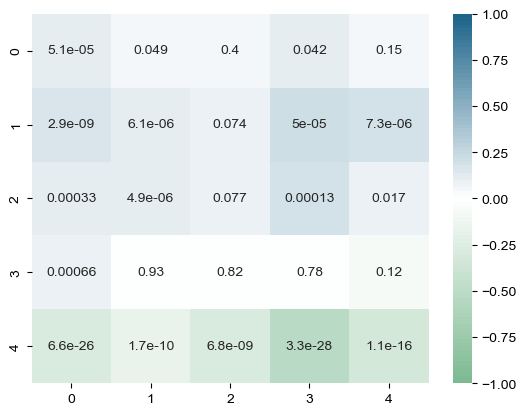

[[ 0.32215319  0.3924578   0.18001047  0.1828819   0.14835026]
 [ 0.52911395  0.48643893  0.2852857   0.35944804  0.4044569 ]
 [ 0.38936072  0.25158989  0.16353187  0.28546508  0.29221542]
 [ 0.2876919   0.27964237  0.0421999   0.0675297   0.03406888]
 [-0.9314691  -0.85953972 -0.85662665 -0.90290014 -0.87263696]]


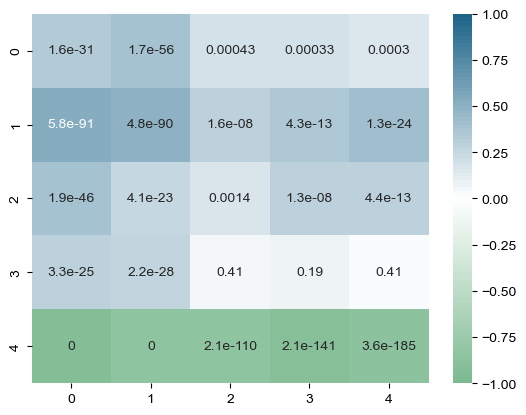

In [117]:
from scipy.stats import spearmanr

from scipy.stats import ttest_rel, ttest_ind

heatmap_palette = sns.color_palette(sns.blend_palette([bars_palette[0], "#FFFFFF", bars_palette[4]], n_colors=100))

# metrics = ['recall', 'precision', 'map', 'iou', 'f1score', 'ratio', 'perc aglomerated']
# datasets = df_nnUNet_analysis_excALL["dataset"].unique()

morphologies = ['Morph_Round', 'Morph_Branched', 'Morph_hBranched', 'Morph_Cluster', 'Morph_Other/Unknown']
cultures = ['Fibrin','5mM', '50mM', '100mM', '175mM']

identities = ['SOX9_Positive', 'GFAP_Positive']

spearman = np.zeros(shape=(len(morphologies), len(cultures)))
pvalues = np.zeros(shape=(len(morphologies), len(cultures)))


for ident in identities:
    
       for m, morph in enumerate(morphologies):
              for c, cult in enumerate(cultures):
                     s, p = spearmanr(dummies[dummies['Culture ID']==cult][morph], dummies[dummies['Culture ID']==cult][ident])

                     spearman[m,c] = s
                     pvalues[m,c] = p

# spearmanr(dummies['Morph_Cluster'], dummies['GFAP_Positive'])

       print(spearman)

       sns.heatmap(spearman, cmap=heatmap_palette, annot=pvalues, annot_kws={"size":10}, vmin=-1, vmax=1)

       # print(ttest)
       plt.show()

In [122]:
np.std([[0.1143802, 0.05083525,  0.04364599,  0.10433236,  0.05963789],
 [ 0.16709957,  0.11641114,  0.09190252,  0.20593635,  0.18342284],
 [ 0.10155398,  0.11759269,  0.09097591,  0.19469379,  0.09804808]])

0.048973326806482115

In [128]:
np.mean([[0.18001047,  0.1828819 ,  0.14835026]])


0.17041420999999998

In [130]:
np.mean( [[0.2852857   ,0.35944804  ,0.4044569 ],
 [0.16353187,  0.28546508 , 0.29221542]])

0.29840050166666665

In [6]:
import numpy as np
np.std([
 [ 0.52911395  ,0.48643893,  0.2852857  , 0.35944804  ,0.4044569 ],
 [ 0.38936072 , 0.25158989 , 0.16353187 , 0.28546508 , 0.29221542]])

0.10543540671514205